# Conjugate Gradient Iterative Method

We implement the conjugate gradient iterative method for solving the following equation:

$$
\begin{array}{ccc}
\begin{bmatrix}
4 & -1 & 0 & -1 & 0 & 0 & 0 & 0 & 0 \\
-1 & 4 & -1 & 0 & -1 & 0 & 0 & 0 & 0 \\
0 & -1 & 4 & 0 & 0 & -1 & 0 & 0 & 0 \\
-1 & 0 & 0 & 4 & -1 & 0 & -1 & 0 & 0 \\
0 & -1 & 0 & -1 & 4 & -1 & 0 & -1 & 0 \\
0 & 0 & -1 & 0 & -1 & 4 & 0 & 0 & -1 \\
0 & 0 & 0 & -1 & 0 & 0 & 4 & -1 & 0 \\
0 & 0 & 0 & 0 & -1 & 0 & -1 & 4 & -1 \\
0 & 0 & 0 & 0 & 0 & -1 & 0 & -1 & 4 \\
\end{bmatrix}
&
\begin{bmatrix}
x_0 \\
x_1 \\
x_2 \\
x_3 \\
x_4 \\
x_5 \\
x_6 \\
x_7 \\
x_8 \\
\end{bmatrix}
&
=
\begin{bmatrix}
\frac{1}{16} \\
\frac{1}{16} \\
\frac{1}{16} \\
\frac{1}{16} \\
\frac{1}{16} \\
\frac{1}{16} \\
\frac{1}{16} \\
\frac{1}{16} \\
\frac{1}{16} \\
\end{bmatrix}
\end{array}
$$

The case when $N = 3$ is shown. For general $N$, $A$ is $N^2 \times N^2$ and has the block tridiagonal form

$$
\begin{bmatrix}
C & -I \\
-I & C & -I \\
& \ddots & \ddots & \ddots \\
& & -I & C & -I \\
& & & -I & C \\
\end{bmatrix}
$$

where $I$ is the $N \times N$ identity matrix and $C$ is the tridiagonal matrix

$$
\begin{bmatrix}
4 & -1 \\
-1 & 4 & -1 \\
& \ddots & \ddots & \ddots \\
& & -1 & 4 & -1 \\
& & & -1 & 4 \\
\end{bmatrix}
$$

The right-hand side is a vector of ones multiplied by $h^2 = \frac{1}{(N +1)^2}$.


## The conjugate gradient algorithm 

In [4]:
import numpy as np
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
from copy import copy, deepcopy

# Define getsystem Function that gets the required matrices
def getsystem(N):
    h = 1./(N+1.)
    C = 2*np.eye(N) + np.diag(-np.ones(N-1),k=1) + np.diag(-np.ones(N-1),k=-1)
    A = np.kron(C,np.eye(N)) + np.kron(np.eye(N),C)
    b = np.full(N*N,h**2)
    return A, b

#### Conjugate Gradient (CG)

In [5]:
"""
Steepest descent
Input variables:
    A: input matrix
    b: right hand side
    x: initial guess
Optional parameters {Default values}:
    tol : ||A@x-b||<tol   {1e-10}.
    xtol: ||x-xold||<xtol {1e-10}.
    maxiter: maximum mumber of iterations {1000}
    verbose: print statistics {False}
    stats:   return statistics {True}
"""
def cg(A,b,xo,tol=1e-10,xtol=1e-10,maxiter=1000,verbose=False,stats=True):    
    flag = False
    x = np.array(xo)
    R = np.zeros(maxiter)
    r = b - A@x # b - np.dot(A,x)
    p = deepcopy(r) 
    
    # Main loop    
    for k in range(maxiter):
        
        a = np.dot(r,r)/np.dot(p,A@p)
        rk = deepcopy(r)
        r -= a*np.dot(A,p)
        c = a*p
        x += c
        bt = np.dot(r,r)/np.dot(rk,rk)
        p = r + bt*p
        
        
        # Check convergence    
        res = np.linalg.norm(r)
        dx = np.linalg.norm(c) #c = x-xold
        R[k] = res
        if res<tol or dx<xtol:
            flag = True         
            break
        
    if verbose:
        print('Residual norm:',res)
        print('Change in x:',dx)
        print('Iterations:',k+1) 
        if flag!=True:
            print('Convergence criteria not met')
    
    if stats:
        R = (np.arange(k+1),R[:k+1])
        return x,R
    else:
        return x

#### Successive over-relaxation algorithm

In [6]:
"""
Successive over relaxation iteration
Input variables:
    A: input matrix
    b: right hand side
    x: initial guess
Optional parameters {Default values}:
    omega : 1 (Gauss-Siedel)
    tol : ||A@x-b||<tol   {1e-10}.
    xtol: ||x-xold||<xtol {1e-10}.
    maxiter: maximum mumber of iterations {1000}
    verbose: print statistics {True}
    stats:   return statistics {True}
"""
def sor(A,b,xo,omega=1.,tol=1e-10,xtol=1e-10,maxiter=1000,verbose=False,stats=True):
    # Implementation of SOR and Gauss-Siedel    
    N = A.shape[0]
    flag = False
    R = np.zeros(maxiter)
    x = np.array(xo) # xo.copy()
    
    # Main loop    
    for k in range(maxiter):
        # Keep the previous iteration to check convergence
        xold = np.array(x)
        
        # Update solution
        for i in range(N):
            #x[i]= (1-omega)*x[i] + omega/A[i,i]*(b[i]  -np.dot(A[i,:i],x[:i])  - np.dot(A[i,i+1:],x[i+1:]))
            x[i] +=  omega/A[i,i]*(b[i]  -np.dot(A[i],x))
            
        # Check convergence    
        res = np.linalg.norm(A@x-b)
        dx = np.linalg.norm(x-xold)
        R[k] = res
        if res<tol or dx<xtol:
            flag = True         
            break
        
    if verbose:
        print('ω:',omega)
        print('Residual norm:',res)
        print('Change in x:',dx)
        print('Iterations:',k+1) 
        if flag!=True:
            print('Convergence criteria not met')
    
    if stats:
        R = (np.arange(k+1),R[:k+1])
        return x,R
    else:
        return x

#### Convergence Plot of SOR and steepd

ω: 1.673513677715992
Residual norm: 8.794096967175842e-11
Change in x: 1.97877187710135e-10
Iterations: 64
Residual norm: 8.572156685305373e-11
Change in x: 1.2857898318139293e-10
Iterations: 28


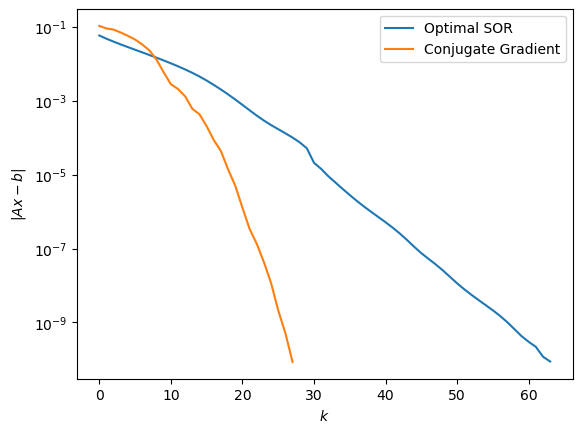

In [8]:
N = 15
A, b = getsystem(N)
omega0 = 2./(1.+np.sin(np.pi/(N+1))) #Optimal value of ω

x,R = sor(A,b,np.zeros(N*N),omega=omega0,verbose=True)
plt.semilogy(*R,label='Optimal SOR')

x,R = cg(A,b,np.zeros(N*N),verbose=True)
plt.semilogy(*R,label='Conjugate Gradient')

plt.xlabel('$k$')
plt.ylabel('$\|Ax-b\|$')
plt.legend()
plt.show()

# Condition number of a matrix

Here we want to find the largest and smallest singular values of $A$, which correspond to the square roots of the largest and smallest eigenvalues of the matrix $C = A^T A$. This matrix is symmetric and hence positive definite with eigenvalues $\geq 0$. Hence for the smallest eigenvalue of $C$, $\sigma_m$ we pick the shift $\alpha_m = 0$; for the largest eigenvalue, we use that
$ \rho(C) = \sigma_1 \leq \lVert C \rVert $
for any matrix norm. The command `sum(abs(C)).max()` computes the maximum column sum which is equivalent to $\lVert C \rVert_1$, whereas `sum(abs(C.T)).max()` is the maximum column sum which is equivalent to $\lVert C \rVert_\infty$. We then take the smallest of the two in order to obtain a tighter bound on $\sigma_1$ in accordance with the formula above, which will be used as the shift in our shift algorithm.

The steps followed to compute the condition number are outlined below:
- **Step 1:** Compute the symmetric matrix $C = A^T A$, whose maximum and minimum eigenvalues are to be estimated.
- **Step 2:** Compute the QR factors for the shift and inverse algorithm to expedite the process of repeatedly inverting the linear equations required by the algorithm.
- **Step 3:** Apply the shift and inverse algorithm to obtain estimates. The largest and smallest eigenvalues $C$ correspond to $\lambda_{C,1} = \sigma_1^2$ and $\lambda_{C,m} = \sigma_m^2$, respectively.
- **Step 4:** Compute an estimate of the condition number using
$ \kappa(A) = \frac{\sigma_1}{\sigma_m} = \sqrt{\frac{\lambda_{C,1}}{\lambda_{C,m}}} $



In [16]:
# QR factorization
def mgs(Ao):
    n = len(Ao)
    A = np.array(Ao)
    Q = np.zeros([n,n])
    R = np.zeros([n,n])
    for i in range(n):
        R[i,i] = np.linalg.norm(A[:,i])
        Q[:,i] = A[:,i]/R[i,i]
        
        for j in range(i+1,n):
            R[i,j] = np.dot(Q[:,i],A[:,j])
            A[:,j] -= R[i,j]*Q[:,i]
        
    return Q, R

# Backward subtitution function
def bwd_subs(A,b):
    x = np.zeros(b.shape)
    x[-1] = b[-1]/A[-1,-1]
    
    for i in range(len(b)-2,-1,-1):
        x[i] = (b[i] - A[i,i+1:] @ x[i+1:])/A[i,i]  # Note: A[i,:i]@x[:i] = np.dot(A[i,:i],x[:i])       
    return x



# Condition number computation of a given matrix A 
def kappa (A, maxiter =1000 , tol = 1e-12):
    # maxiter : maximum number of iterations before giving up
    # tol : relative tolerance to terminate iteration

    dim = len(A) # get dimension of matrix
    
    C = A.T@A
    
    a1 = min(sum(abs(C.T)).max(),sum(abs(C)).max())
    am = 0 
    
    Q1, R1 = mgs(C-a1*np.eye(dim))
    Qm, Rm = mgs(C)
    
    u1 = np.random.rand(dim)/np.linalg.norm(np.random.rand(dim))
    um = np.random.rand(dim)/np.linalg.norm(np.random.rand(dim)) # Generate two random unit vectors
    
    lambda1 = u1.T@C@u1
    lambdam = um.T@C@um
    
    # Initialize kappa for checking
    kap = 1
    for i in range ( maxiter ):
        
        x1 = bwd_subs(R1,Q1.T@u1)
        xm = bwd_subs(Rm,Qm.T@um)
        
        u1 = x1/np.linalg.norm(x1)
        um = xm/np.linalg.norm(xm)
        
        lambda1 = u1.T@C@u1
        lambdam = um.T@C@um 
        
        # Check convergence
        kap_old = kap
        kap = np.sqrt(lambda1/lambdam)# [**Your code here**]
        if abs (1- kap_old /kap)<tol:
            break
            
        # Issue warning
        if i== maxiter -1:
            print ('No convergence after '+str( maxiter )+'iterations ')
    return kap

In [17]:
# Testing matrices
N = 10
h = 1./( N +1.)
J = np. diag (-np. ones (N -1) ,k=1)+np. diag (-np. ones (N -1) ,k= -1) +4* np.eye (N)
A = block_diag (*([ J]*N))+np. diag (-np. ones (N*N-N),k=N)+np. diag (-np. ones (N*N-N),k=-N)

In [18]:
N = 100
B = 2*( np. random . rand (N,N) + np.eye(N)) - 1

#### Test and compare the program

In [19]:
print("The difference between between our program and python for matrices is:") 
print("A=",kappa(A)-np.linalg.cond(A), "|----|","B=", kappa(B)-np.linalg.cond(B))

The difference between between our program and python for matrices is:
A= -3.929301328753354e-12 |----| B= -4.374584250399494e-09
